In [6]:
# Before delving into the implementation of YOLOv8 for our Proof of Concept (PoC), 
# it's crucial to consider a few key aspects regarding the dataset provided by Spare-it. 
# There are notable characteristics we must address to ensure the success of our model.

# Firstly, our dataset exhibits class imbalance, where certain recyclable 
# classes are underrepresented or absent entirely. For instance, labels 
# like "paper towel" may occur frequently, while others may be scarce. 
# To mitigate this imbalance, we plan to leverage pretrained models. 
# These models not only help address class imbalances but also enhance the 
# overall accuracy of our model as Spare-it's dataset expands and evolves.

# Furthermore, within our dataset, we encounter a distinction between material 
# classes and specific names (e.g., "paper towel"). Notably, the material class 
# serves as a superclass encompassing various specific names. Therefore, achieving 
# optimal performance on these specific names is crucial for enhancing the overall model accuracy.

# Our initial step involves transforming Spare-it's dataset, currently in cocojson 
# format, to align with the requirements of YOLOv8's dataset. Initially, we prioritize 
# handling bounding boxes (bbox) and defer addressing segmentation aspects until we achieve satisfactory accuracy levels.

In [7]:
# You will need to have images folder with all the images and cocojson folder with all the labels to run codes below.
import json
import os

# Your directories
coco_dir = './cocojson'  # Directory containing COCO JSON files
labels_dir = './labels'  # Final directory to save the YOLO format files

# remove exisiting labels folder if it exist
def delete_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)
delete_directory(labels_dir)

# These are index mapping we have to do.
# YOLOv8 needs your name starting from 0 incrementing by 1.
# Spare-it has id values not in this format, so we have mapped them in this way.
# id_to_index = {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9, 
#                14: 10, 15: 11, 16: 12, 17: 13, 18: 14, 19: 15, 115: 16, 114: 17, 
#                116: 18, 117: 19, 122: 20, 123: 21, 124: 22, 127: 23, 20: 24, 21: 25, 
#                22: 26, 23: 27, 24: 28, 25: 29, 26: 30, 27: 31, 30: 32, 125: 33, 126: 34, 
#                36: 35, 38: 36, 40: 37, 43: 38, 44: 39, 45: 40, 46: 41, 47: 42, 48: 43, 
#                49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 
#                58: 53, 59: 54, 60: 55, 120: 56, 121: 57, 63: 58, 65: 59, 66: 60, 67: 61, 
#                68: 62, 69: 63, 70: 64, 72: 65, 73: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 
#                82: 72, 83: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 118: 79, 119: 80, 89: 81, 
#                91: 82, 92: 83, 93: 84, 94: 85, 95: 86, 96: 87, 97: 88, 98: 89, 99: 90, 100: 91, 
#                101: 92, 102: 93, 103: 94, 106: 95, 107: 96, 109: 97, 110: 98, 112: 99}

id_to_index = {
    16: 0,
    101: 1,
    20: 2,
    95: 3,
    96: 4,
    116: 5,
    83: 6,
    52: 7,
    1: 8,
    89: 9,
    30: 10,
    99: 11,
    78: 12,
    92: 13,
    51: 14,
    2: 15,
    63: 16,
    119: 17,
    76: 18,
    24: 19,
}

# Function to read Spare-it's custom COCO json into standardized YOLO format.
# I am basing this off from Ultralytics' JSON2YOLO.
# Reason building custom one is to have the id_to_index mapping within coco_to_yolo.
def coco_to_yolo(coco_json_path, labels_dir, id_to_index):
    with open(coco_json_path) as f:
        data = json.load(f)
    
    # We will need image_width, image_height, and overall annotation here
    for image in data['images']:
        image_width, image_height = image['width'], image['height']
        yolo_annotations = [] # our converted yolo data format

        for annotation in data['annotations']:
            category_id = id_to_index.get(annotation['category_id'], None) # convert category_id using the id_to_index mapping
            if category_id is not None:
                x_min, y_min, bbox_width, bbox_height = annotation['bbox']
                x_center = x_min + (bbox_width / 2)
                y_center = y_min + (bbox_height / 2)
    
                x_center_normalized = x_center / image_width
                y_center_normalized = y_center / image_height
                width_normalized = bbox_width / image_width
                height_normalized = bbox_height / image_height
                if (
                    0 <= x_center_normalized <= 1
                    and 0 <= y_center_normalized <= 1
                    and 0 <= width_normalized <= 1
                    and 0 <= height_normalized <= 1
                ):
                    yolo_format = f"{category_id} {x_center_normalized} {y_center_normalized} {width_normalized} {height_normalized}"
                    yolo_annotations.append(yolo_format)
            else:
                continue # do something if if you want log something with skipping labels

        base_filename = os.path.splitext(os.path.basename(coco_json_path))[0]
        output_filename = os.path.join(labels_dir, f"{base_filename}.txt")
        
        # Write output into YOLO format
        with open(output_filename, 'w') as f:
            for item in yolo_annotations:
                f.write("%s\n" % item)


# Creates labels directory and iterate over all cocojson files to that folder
def convert_directory(coco_dir, labels_dir, id_to_index):
    if not os.path.exists(labels_dir):
        os.makedirs(labels_dir)
        
    for filename in os.listdir(coco_dir):
        if filename.endswith(".json"):
            coco_json_path = os.path.join(coco_dir, filename)
            coco_to_yolo(coco_json_path, labels_dir, id_to_index)


convert_directory(coco_dir, labels_dir, id_to_index)

In [1]:
# Now we have all the data formatted to conduct training the model.
#
# We will need to use the dataset.yml, I have generated.
# Looks through the YOLO format id to get the label name and figure out where the train and val images are at.
# We will need to create a main folder called datasets. Inside this there will be train and val folders. Inside each
# of these three folder, we will have images and labels folder. By doing this you will be able to customize YOLOv8 model with own dataset.
import os
import shutil
import random

# remove exisiting datasets folder if it exist
def delete_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)      
delete_directory('./datasets')

# Generate YOLO custom dataset format
subfolders = ['train', 'val']
for subfolder in subfolders:
    os.makedirs(os.path.join('./datasets', subfolder, 'images'), exist_ok=True)
    os.makedirs(os.path.join('./datasets', subfolder, 'labels'), exist_ok=True)

# # Base dataset to create these splits
labels_path = './labels'
images_path = './images'
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

label_files = [file for file in os.listdir(labels_path) if file.endswith('.txt')]
# random.shuffle(label_files)  # Randomize the list

# # Calculate split sizes
# # Change the percentange for your need
num_total = len(label_files) # full 11k images
# num_total = 3000
num_train = int(num_total * 0.85)
num_val = num_total - num_train

# # Split the files
train_files = label_files[:num_train]
val_files = label_files[num_train:num_total]

def copy_files(files, source_path_images, source_path_labels, target_path_images, target_path_labels):
    for file in files:
        base_filename = os.path.splitext(file)[0]
        # Attempt to find and copy the first matching image file with any of the specified extensions
        copied = False
        for ext in image_extensions:
            image_file = base_filename + ext
            if os.path.exists(os.path.join(source_path_images, image_file)):
                shutil.copy(os.path.join(source_path_images, image_file),
                            os.path.join(target_path_images, image_file))
                copied = True
                break  # stops after first match
        if not copied:
            print(f"No matching image found for {file}")
        else:
            shutil.copy(os.path.join(source_path_labels, file), os.path.join(target_path_labels, file)) # Only add labels file if image exist.
            
# Copy files to respective directories
copy_files(train_files, images_path, labels_path, os.path.join('./datasets', 'train', 'images'), os.path.join('./datasets', 'train', 'labels'))
copy_files(val_files, images_path, labels_path, os.path.join('./datasets', 'val', 'images'), os.path.join('./datasets', 'val', 'labels'))

print(f"Total train files: {len(train_files)}")
print(f"Total valdiation files: {len(val_files)}")

Total train files: 9916
Total valdiation files: 1750


In [22]:
# over sampling and under sampling
import os

def count_category_ids(label_files_directory):
    # Dictionary to store the count of each category ID
    category_counts = {}

    # List all label files in the directory
    label_files = [f for f in os.listdir(label_files_directory) if f.endswith('.txt')]

    # Iterate through each file and count category IDs
    for label_file in label_files:
        with open(os.path.join(label_files_directory, label_file), 'r') as file:
            for line in file:
                parts = line.strip().split()
                if not parts:
                    continue  # skip empty lines
                category_id = int(parts[0])
                if category_id in category_counts:
                    category_counts[category_id] += 1
                else:
                    category_counts[category_id] = 1

    return category_counts

# Path to the directory containing the training label files
train_labels_path = './datasets/train/labels'

# Count the category IDs
category_counts = count_category_ids(train_labels_path)

# Print the category counts
for category_id, count in sorted(category_counts.items()):
    print(f"Category ID {category_id}: {count} occurrences")

Category ID 0: 7920 occurrences
Category ID 1: 7854 occurrences
Category ID 2: 7482 occurrences
Category ID 3: 6895 occurrences
Category ID 4: 6985 occurrences
Category ID 5: 6824 occurrences
Category ID 6: 7640 occurrences
Category ID 7: 8020 occurrences
Category ID 8: 6363 occurrences
Category ID 9: 6987 occurrences
Category ID 10: 8040 occurrences
Category ID 11: 8094 occurrences
Category ID 12: 6020 occurrences
Category ID 13: 6388 occurrences
Category ID 14: 6756 occurrences
Category ID 15: 5913 occurrences
Category ID 16: 6531 occurrences
Category ID 17: 8528 occurrences
Category ID 18: 8664 occurrences
Category ID 19: 24653 occurrences


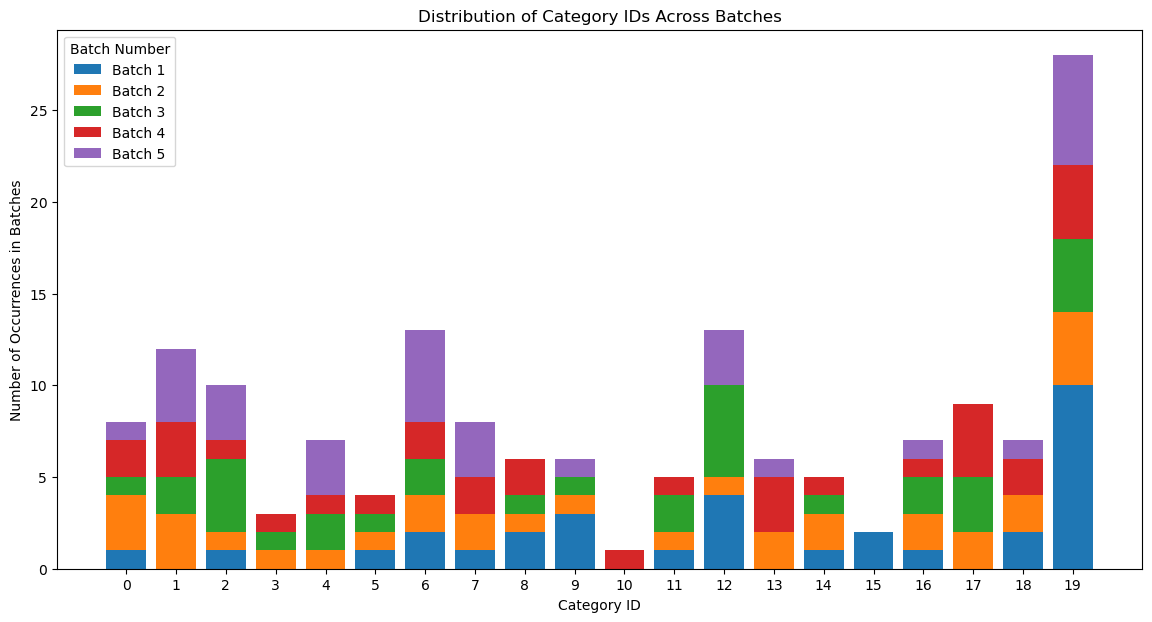

In [24]:
import os
import random
import matplotlib.pyplot as plt

def simulate_batches(category_counts, batch_size, num_batches):
    # Create a list of category IDs repeated according to their counts
    all_ids = []
    for category_id, count in category_counts.items():
        all_ids += [category_id] * count
    
    # Shuffle the list to simulate random sampling
    random.shuffle(all_ids)
    
    # Distribute IDs into batches
    batches = [all_ids[i:i + batch_size] for i in range(0, len(all_ids), batch_size)]
    
    # Create a list to store category counts for each batch
    batch_distributions = []
    for batch in batches[:num_batches]:  # Limit to the first `num_batches` for visualization
        batch_count = {}
        for id in batch:
            if id in batch_count:
                batch_count[id] += 1
            else:
                batch_count[id] = 1
        batch_distributions.append(batch_count)
    
    return batch_distributions

def plot_batch_distributions(batch_distributions):
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 7))
    category_ids = sorted(category_counts.keys())
    for i, dist in enumerate(batch_distributions):
        counts = [dist.get(cid, 0) for cid in category_ids]
        ax.bar(category_ids, counts, bottom=[sum([batch_distributions[j].get(cid, 0) for j in range(i)]) for cid in category_ids], label=f'Batch {i + 1}')
    
    ax.set_xlabel('Category ID')
    ax.set_ylabel('Number of Occurrences in Batches')
    ax.set_title('Distribution of Category IDs Across Batches')
    ax.legend(title="Batch Number")
    plt.xticks(category_ids)
    plt.show()

# Simulate batches
batch_size = 32
num_batches = 5
batch_distributions = simulate_batches(category_counts, batch_size, num_batches)

# Plot the distribution across batches
plot_batch_distributions(batch_distributions)

In [21]:
import os

def calculate_factors(category_counts):
    # Determine the maximum count to match all categories to
    target_count = max(category_counts.values())
    one_third_target = target_count // 3  # Calculate 1/3 of the maximum count

    # Create a dictionary of factors for how many times to duplicate each entry
    factors = {}
    for cat_id, count in category_counts.items():
        required_count = one_third_target - count
        if required_count > 0:
            additional_copies = required_count // count
            factors[cat_id] = additional_copies
        else:
            factors[cat_id] = 0  # No duplication needed if the count is already at or above 1/3 target

    return factors

def oversample_labels(label_dir, factors):
    # Process each label file in the directory
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    for file in label_files:
        new_lines = []
        file_path = os.path.join(label_dir, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Append duplicates according to the factor, with slight modifications
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue  # skip empty lines
            category_id = int(parts[0])
            new_lines.append(line)  # append original line
            # Create duplicates with slight modifications
            for i in range(factors.get(category_id, 0)):
                modified_line = modify_coordinates(parts, i + 1)
                new_lines.append(modified_line)

        # Rewrite the file with the original and modified duplicated lines
        with open(file_path, 'w') as f:
            f.writelines(new_lines)

def modify_coordinates(parts, modification_index):
    x = float(parts[1])
    y = float(parts[2])
    w = float(parts[3])
    h = float(parts[4])

    increment = 0.0001 * modification_index # 0.0000001 is the smallest change it allows. Can't go more smaller.

    # Apply this increment to the x and y coordinates
    new_x = x + increment
    new_y = y + increment

    # Ensure the modified coordinates do not exceed 1.0
    new_x = min(new_x, 1.0)
    new_y = min(new_y, 1.0)

    # Return the modified line with high precision formatting
    return f"{parts[0]} {new_x} {new_y} {w} {h}\n"

label_dir = './datasets/train/labels'
factors = calculate_factors(category_counts)
print(sorted(category_counts.items()))
print(sorted(factors.items())) # this is the multiplier of over sampling
oversample_labels(label_dir, factors)

[(0, 880), (1, 1122), (2, 1247), (3, 1379), (4, 1397), (5, 1706), (6, 1910), (7, 2005), (8, 2121), (9, 2329), (10, 2680), (11, 2698), (12, 3010), (13, 3194), (14, 3378), (15, 5913), (16, 6531), (17, 8528), (18, 8664), (19, 24653)]
[(0, 8), (1, 6), (2, 5), (3, 4), (4, 4), (5, 3), (6, 3), (7, 3), (8, 2), (9, 2), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0)]


In [24]:
# Now you have to train using the Ultralytics, Albumentation
# Also could use wandb to visualize overall dataset easily
!pip install -q ultralytics
!pip install -q albumentations
!pip install -q wandb

In [5]:
# import wandb
# wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# from ultralytics import YOLO
# from wandb.integration.ultralytics import add_wandb_callback
# import wandb
# from ultralytics.data.augment import Albumentations

# # Step 1: Initialize a Weights & Biases run
# wandb.init(project="ultralytics", job_type="training")

# # Step 2: Define the YOLOv8 Model and Dataset
# model = YOLO('yolov8n.pt')

# # Step 3: Add W&B Callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# # Step 4: Train and Fine-Tune the Model
# model.train(
#     project="ultralytics",
#     data='dataset.yaml', # custom dataset
#     epochs=3, # default 100 ~ higher epoch was worse went to like 38
#     imgsz=640, # default 640 ~ imgsz didn't change the end result
#     batch=32, # default 16,~8 was bad
#     patience=2, # default 100
#     dropout=0.0, # default 0.0 ~ anything on above 0.1 was bad,
#     # label_smoothing=0.5, # default 0.0
#     augment=True
# )

# # Step 5: Validate the Model
# model.val()

# # Step 6: Perform Inference and Log Results
# model(["./images/Compost_000eeeeb-0444-4f74-91e3-d6329c6e9c85_ec3a2daf-29b4-4804-9216-e6a71b07a335_35addbdb-52aa-42ac-a9c7-26ed974484f7.jpeg"])

# # Step 7: Finalize the W&B Run
# wandb.finish()

In [ ]:
# data augmentation using Albumentations
# from ultralytics.data.augment import Albumentations

# from ultralytics.utils import LOGGER, colorstr
# def __init__(self, p=1.0):
#         """Initialize the transform object for YOLO bbox formatted params."""
#         self.p = p
#         self.transform = None
#         prefix = colorstr("albumentations: ")
#         try:
#             import albumentations as A         

#             # Insert required transformation here
#             T = [
#                 # # A.RandomRain(p=0.1, slant_lower=-10, slant_upper=10, 
#                 # #               drop_length=20, drop_width=1, drop_color=(200, 200, 200), 
#                 # #               blur_value=5, brightness_coefficient=0.9, rain_type=None),
#                 # # A.Rotate(limit = 10, p=0.5),
#                 # # A.Blur(p=0.1),
#                 # # A.MedianBlur(p=0.1),
#                 # # A.ToGray(p=0.01),
#                 # # A.CLAHE(p=0.01),
#                 # # A.ImageCompression(quality_lower=75, p=0.0),
                
#                 # A.Rotate(limit=15, p=0.5),  # Moderate rotation
#                 # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),  # Lighting variation
#                 # A.HorizontalFlip(p=0.5),  # Horizontal flip for symmetry
#                 # # A.GaussianBlur(blur_limit=(3, 7), p=0.2),  # Mild blur to simulate focus issues
#                 # # A.GaussNoise(var_limit=(10, 50), p=0.1),  # Simulate sensor noise
#                 A.Rotate(limit=(15, 15), p=0.5),  # Ensure limits are tuples
#                 A.RandomBrightnessContrast(brightness_limit=(0.2, 0.2), contrast_limit=(0.2, 0.2), p=0.3),
#                 A.HorizontalFlip(p=0.5),
#                 A.Perspective(scale=(0.05, 0.1), p=0.5),
#                 A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),  # Ensure scale and ratio are tuples
#                 A.Resize(640, 640, p=1.0)
#             ]
#             self.transform = A.Compose(T, bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))

#             LOGGER.info(prefix + ", ".join(f"{x}".replace("always_apply=False, ", "") for x in T if x.p))
#         except ImportError:  # package not installed, skip
#             pass
#         except Exception as e:
#             LOGGER.info(f"{prefix}{e}")
# Albumentations.__init__ = __init__


# https://docs.ultralytics.com/modes/train/
# Mix-up vs copy-paste: https://sh-tsang.medium.com/brief-review-simple-copy-paste-is-a-strong-data-augmentation-method-for-instance-segmentation-81297fb6f9ca
# Auto-augmentation: https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
# external augmentation packages: https://medium.com/@k.sunman91/data-augmentation-on-ultralytics-for-training-yolov5-yolov8-97a8dab31fef
from ultralytics import YOLO
# model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')
# model = YOLO('yolov8n.yaml').load('yolov8n.pt') # build from YAML and transfer weights

# these are some tuners for yolov8 https://github.com/ultralytics/ultralytics/blob/156b6be8d37f491a12600d68893ce29debc0caa1/ultralytics/engine/tuner.py#L85
# 'optimizer': tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
# "lr0": (1e-5, 1e-1),  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
# "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
# "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
# "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
# "warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
# "warmup_momentum": (0.0, 0.95),  # warmup initial momentum
# "box": (1.0, 20.0),  # box loss gain
# "cls": (0.2, 4.0),  # cls loss gain (scale with pixels)
# "dfl": (0.4, 6.0),  # dfl loss gain
# "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
# "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
# "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
# "degrees": (0.0, 45.0),  # image rotation (+/- deg)
# "translate": (0.0, 0.9),  # image translation (+/- fraction)
# "scale": (0.0, 0.95),  # image scale (+/- gain)
# "shear": (0.0, 10.0),  # image shear (+/- deg)
# "perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
# "flipud": (0.0, 1.0),  # image flip up-down (probability)
# "fliplr": (0.0, 1.0),  # image flip left-right (probability)
# "bgr": (0.0, 1.0),  # image channel bgr (probability)
# "mosaic": (0.0, 1.0),  # image mixup (probability)
# "mixup": (0.0, 1.0),  # image mixup (probability)
# "copy_paste": (0.0, 1.0),  # segment copy-paste (probability)

results = model.train(
    data='dataset-trunc.yaml', # custom dataset
    epochs=100, # default 100 ~ higher epoch was worse went to like 38
    imgsz=640, # default 640 ~ imgsz didn't change the end result
    batch=32,
    patience=3, # default 100
    dropout=0.0, # default 0.0 ~ anything on above 0.1 was bad,
    # augment=True,
    cls=2,  # Increase classification loss weight https://github.com/ultralytics/ultralytics/issues/10207
    box=13,  # Box loss weight
    # label_smoothing=0.05,
    # dfl=0.5,  # Default DFL weight,
    # nbs=8
)

New https://pypi.org/project/ultralytics/8.2.5 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.37 🚀 Python-3.11.6 torch-2.1.2 CUDA:0 (NVIDIA L40S, 45589MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset-trunc.yaml, epochs=100, time=None, patience=3, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train67, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

train: Scanning /projectnb/spareit/jasonoh/datasets/train/labels... 9916 images, 430 backgrounds, 0 corrupt: 100%|██████████| 9916/9916 [00:04<00:00, 2475.38it/s]

train: WARNING ⚠️ /projectnb/spareit/jasonoh/datasets/train/images/Trash_9a8023cc-2608-41e3-82ed-24e7507e91d5_b7e1275d-5d0e-48b8-af8f-254c49833370_c0f2c1b2-aea6-4cab-ba9a-52b06a92963f.jpeg: 3 duplicate labels removed


train: New cache created: /projectnb/spareit/jasonoh/datasets/train/labels.cache


val: Scanning /projectnb/spareit/jasonoh/datasets/val/labels... 1750 images, 60 backgrounds, 0 corrupt: 100%|██████████| 1750/1750 [00:00<00:00, 2118.59it/s]

val: WARNING ⚠️ /projectnb/spareit/jasonoh/datasets/val/images/Trash_06e4cb92-5753-4a8a-bdc4-43ffad700922_07bd1196-c632-4bf4-a01f-35660b57d624_465ad689-8383-4ae0-b01f-015197a68b4b.jpeg: 1 duplicate labels removed
val: New cache created: /projectnb/spareit/jasonoh/datasets/val/labels.cache


Plotting labels to runs/detect/train67/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train67
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.1G      2.722      13.54      1.481        621        640: 100%|██████████| 310/310 [04:57<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.96it/s]


                   all       1750      15314      0.176      0.208      0.122     0.0716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.31G      2.637      10.18      1.464        836        640:  42%|████▏     | 129/310 [02:15<01:31,  1.97it/s]

In [38]:
results = model("./images/Compost_000eeeeb-0444-4f74-91e3-d6329c6e9c85_ec3a2daf-29b4-4804-9216-e6a71b07a335_35addbdb-52aa-42ac-a9c7-26ed974484f7.jpeg")


image 1/1 /projectnb/spareit/jasonoh/images/Compost_000eeeeb-0444-4f74-91e3-d6329c6e9c85_ec3a2daf-29b4-4804-9216-e6a71b07a335_35addbdb-52aa-42ac-a9c7-26ed974484f7.jpeg: 1280x960 2 Snack or Candy Bag or Wrappers, 2 Compostable Fiber Wares, 6.8ms
Speed: 8.2ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 960)


In [1]:
import os
import shutil

def delete_except_sample1(directory):
    # Get all items in the directory
    items = os.listdir(directory)
    
    # Iterate through items and remove them if they are not 'sample 1'
    for item in items:
        item_path = os.path.join(directory, item)
        if item != "train7":  # Check if the current item is not 'sample 1'
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.remove(item_path)  # Remove the file or link
                print(f"Deleted file: {item_path}")
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)  # Remove the directory
                print(f"Deleted directory: {item_path}")

# Specify the path to the directory
directory_path = './runs/detect/'
delete_except_sample1(directory_path)
print("Cleanup complete.")

Deleted directory: ./runs/detect/.ipynb_checkpoints
Deleted directory: ./runs/detect/train
Deleted directory: ./runs/detect/small-sample-train
Deleted directory: ./runs/detect/train2
Cleanup complete.
